### 1 : Importing Libraries

In [1]:
#make sure your path is set to source folder
%cd /home/Assignment/02_training_pipeline

/home/Assignment/02_training_pipeline


In [2]:
/pwd

'/home/Assignment/02_training_pipeline'

In [3]:
# ignore the warnings in the output
#%pip install pycaret[tuner]

In [4]:
import sys
!{sys.executable} -m pip install numpy

In [5]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from scripts import utils,constants,lead_scoring_training_pipeline
from pycaret.classification import *

import sqlite3
from sqlite3 import Error


 ### 2 Reading Data

In [6]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
%time
csv_file = constants.ROOT_FOLDER+"/notebooks/Data/cleaned_data.csv"
dataset = pd.read_csv(csv_file)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


In [7]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [8]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [9]:
def create_sqlit_connection(db_path,db_file):
     """ create a database connection to a SQLite database """
     conn = None
     # opening the conncetion for creating the sqlite db
     try:
         conn = sqlite3.connect(db_path+db_file)
         print(sqlite3.version)
     # return an error if connection not established
     except Error as e:
         print(e)
     # closing the connection once the database is created
     finally:
         if conn:
             conn.close()

In [10]:
#constants
ROOT_FOLDER = "/home/Assignment/02_training_pipeline/"
DB_PATH = ROOT_FOLDER + "database/"
DB_FILE_NAME = "mlflow_v01.db"

DB_FILE_MLFLOW = "lead_scoring_model_experimentation.db"

TRACKING_URI = "http://0.0.0.0:6006"

In [11]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebooks/' location
create_sqlit_connection(DB_PATH,DB_FILE_MLFLOW)

2.6.0


In [12]:
'''
Now you need to start the MLflow server in a new terminal. 
Note: Before you start the MLflow server, create a folder named mlruns in the assignment directory.
Now you need to run the command to start MLflow server such that:
1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.
2. mlruns folder is used as an artifact directory. 
3. The server runs on the port 6006.

The steps to do so are as follows:
Open a new terminal.
Then go to the Assignment directory using the cd command. Type the command: cd Assignment/
Create a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns
Then, type the following command to start the MLflow server: 
mlflow server --backend-store-uri='sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0
'''

'\nNow you need to start the MLflow server in a new terminal. \nNote: Before you start the MLflow server, create a folder named mlruns in the assignment directory.\nNow you need to run the command to start MLflow server such that:\n1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.\n2. mlruns folder is used as an artifact directory. \n3. The server runs on the port 6006.\n\nThe steps to do so are as follows:\nOpen a new terminal.\nThen go to the Assignment directory using the cd command. Type the command: cd Assignment/\nCreate a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns\nThen, type the following command to start the MLflow server: \nmlflow server --backend-store-uri=\'sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db\' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0\n'

In [13]:
# Once, your server is successfully running, create a mlflow tracking uri at "http://0.0.0.0:6006"
mlflow.set_tracking_uri(TRACKING_URI)

In [14]:
# setup pycaret 
exp_lead_score = setup(data=dataset, target = 'app_complete_flag',  
                   fold_shuffle=True, 
                   session_id = 42,
                   normalize = True, 
                   transformation = True, 
                   remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                   n_jobs=-1,use_gpu=False,
                   log_experiment=True,experiment_name='Lead_scoring_model_experimentation',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


[2023-07-26 15:24:17,150] {__init__.py:190} INFO - Logging experiment in MLFlow
[2023-07-26 15:24:17,434] {__init__.py:202} INFO - SubProcess save_model() called ==================================
[2023-07-26 15:24:17,455] {persistence.py:289} INFO - Initializing save_model()
[2023-07-26 15:24:17,456] {persistence.py:290} INFO - save_model(model=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='app_complete_flag',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=Non

### 4 : Model Experimentation with pycaret

In [15]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
exclude_lst = ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(fold=5,exclude=exclude_lst)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7382,0.8210,0.8276,0.7038,0.7607,0.4758,0.4835,8.6400
lightgbm,Light Gradient Boosting Machine,0.7382,0.8211,0.8325,0.7022,0.7618,0.4759,0.4845,1.2000
rf,Random Forest Classifier,0.7373,0.8186,0.8250,0.7037,0.7595,0.4741,0.4814,2.7920
et,Extra Trees Classifier,0.7366,0.8178,0.8203,0.7044,0.7579,0.4726,0.4793,3.4460
dt,Decision Tree Classifier,0.7363,0.8169,0.8199,0.7042,0.7577,0.4721,0.4787,0.1800
lr,Logistic Regression,0.7174,0.7917,0.8028,0.6875,0.7407,0.4342,0.4405,1.3760
lda,Linear Discriminant Analysis,0.7151,0.7904,0.8138,0.6814,0.7417,0.4295,0.4380,0.3080
ridge,Ridge Classifier,0.7150,0.0000,0.8138,0.6814,0.7417,0.4294,0.4378,0.0860
nb,Naive Bayes,0.6789,0.7383,0.8537,0.6343,0.7278,0.3565,0.3804,0.4540


[2023-07-26 15:26:10,936] {tabular.py:2362} INFO - create_model_container: 9
[2023-07-26 15:26:10,937] {tabular.py:2363} INFO - master_model_container: 9
[2023-07-26 15:26:10,938] {tabular.py:2364} INFO - display_container: 2
[2023-07-26 15:26:10,942] {tabular.py:2366} INFO - XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=True, validate_parameters=1, verbosity=0)
[2023-07-26 15:26:10

In [16]:
# create a model which gives the highest accuracy
lgbm  = create_model('lightgbm', fold = 5)

[2023-07-26 15:26:21,159] {tabular.py:3321} INFO - create_model_container: 10
[2023-07-26 15:26:21,160] {tabular.py:3322} INFO - master_model_container: 10
[2023-07-26 15:26:21,160] {tabular.py:3323} INFO - display_container: 3
[2023-07-26 15:26:21,161] {tabular.py:3325} INFO - LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
[2023-07-26 15:26:21,162] {tabular.py:3326} INFO - create_model() succesfully completed......................................


In [17]:
lgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

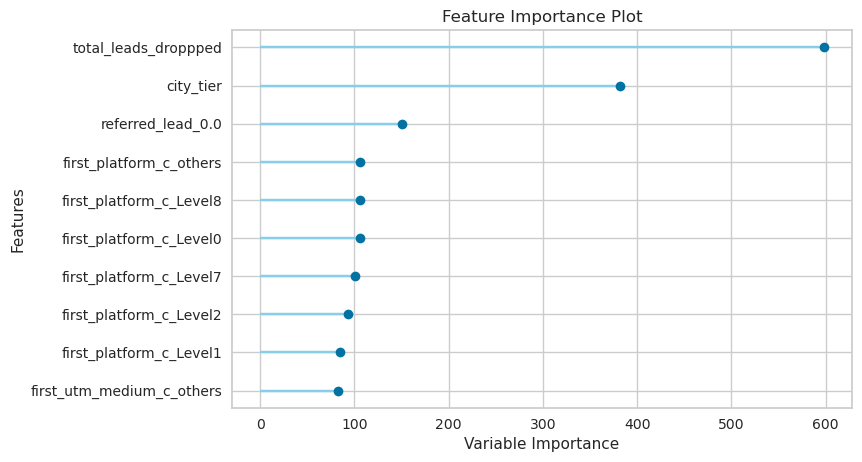

[2023-07-26 15:26:21,513] {tabular.py:7575} INFO - Visual Rendered Successfully
[2023-07-26 15:26:21,666] {tabular.py:7635} INFO - plot_model() succesfully completed......................................


In [18]:
# create feature importance plot
%matplotlib inline
plot_model(lgbm, plot='feature') #feature_all -> to check for all features 

### 5 : Model Experimentation after dropping features

From the above feature tests we can clearly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [19]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.

imp_cols = ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
new_dataset = dataset[imp_cols]

In [20]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
exp2 = setup(data=new_dataset, target = 'app_complete_flag',  
                    remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                    normalize=False,
                    transformation=False,
                    categorical_features = ['city_tier', 'first_platform_c','first_utm_medium_c', 'first_utm_source_c'],
                    fold_shuffle=True, 
                    session_id = 42,
                    n_jobs=-1,use_gpu=False,
                    log_experiment=True,experiment_name='Lead_scoring_model_after_dropping',
                    log_plots=True, log_data=True,
                    silent=True, verbose=True,
                    log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 7)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


[2023-07-26 15:26:26,369] {__init__.py:190} INFO - Logging experiment in MLFlow


2023/07/26 15:26:26 INFO mlflow.tracking.fluent: Experiment with name 'Lead_scoring_model_after_dropping' does not exist. Creating a new experiment.


[2023-07-26 15:26:26,513] {__init__.py:202} INFO - SubProcess save_model() called ==================================
[2023-07-26 15:26:26,530] {persistence.py:289} INFO - Initializing save_model()
[2023-07-26 15:26:26,531] {persistence.py:290} INFO - save_model(model=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['city_tier',
                                                            'first_platform_c',
                                                            'first_utm_medium_c',
                                                            'first_utm_source_c'],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='app_complete_flag',
                                      t

In [21]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret
best_model2 = compare_models(fold=5,exclude=exclude_lst)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7384,0.8211,0.8314,0.7027,0.7616,0.4762,0.4845,1.1600
xgboost,Extreme Gradient Boosting,0.7381,0.8209,0.8277,0.7037,0.7607,0.4757,0.4834,8.1980
rf,Random Forest Classifier,0.7372,0.8185,0.8245,0.7037,0.7593,0.4739,0.4811,2.7500
et,Extra Trees Classifier,0.7364,0.8176,0.8203,0.7042,0.7578,0.4723,0.4790,3.4840
dt,Decision Tree Classifier,0.7363,0.8170,0.8200,0.7042,0.7577,0.4720,0.4787,0.1840
lr,Logistic Regression,0.7100,0.7843,0.8218,0.6734,0.7403,0.4193,0.4300,0.7740
ridge,Ridge Classifier,0.7003,0.0000,0.7959,0.6700,0.7276,0.3999,0.4073,0.0880
lda,Linear Discriminant Analysis,0.7003,0.7733,0.7959,0.6700,0.7276,0.3999,0.4073,0.2900
nb,Naive Bayes,0.6725,0.7338,0.8567,0.6278,0.7246,0.3437,0.3695,0.0940


[2023-07-26 15:28:05,366] {tabular.py:2362} INFO - create_model_container: 9
[2023-07-26 15:28:05,367] {tabular.py:2363} INFO - master_model_container: 9
[2023-07-26 15:28:05,368] {tabular.py:2364} INFO - display_container: 2
[2023-07-26 15:28:05,370] {tabular.py:2366} INFO - LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
[2023-07-26 15:28:05,371] {tabular.py:2367} INFO - compare_models() succesfully completed......................................


In [22]:
#Our best performing lgbm model is 
lgbm2 = create_model('lightgbm', fold=5)

[2023-07-26 15:28:18,210] {tabular.py:3321} INFO - create_model_container: 10
[2023-07-26 15:28:18,211] {tabular.py:3322} INFO - master_model_container: 10
[2023-07-26 15:28:18,211] {tabular.py:3323} INFO - display_container: 3
[2023-07-26 15:28:18,212] {tabular.py:3325} INFO - LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
[2023-07-26 15:28:18,213] {tabular.py:3326} INFO - create_model() succesfully completed......................................


In [23]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC
lgbm_optuna,tunr_op = tune_model(lgbm2,
                                fold = 10,
                                optimize = 'AUC',
                                choose_better = True, 
                                return_tuner=True)

[2023-07-26 15:29:54,797] {tabular.py:4722} INFO - create_model_container: 12
[2023-07-26 15:29:54,798] {tabular.py:4723} INFO - master_model_container: 12
[2023-07-26 15:29:54,798] {tabular.py:4724} INFO - display_container: 4
[2023-07-26 15:29:54,799] {tabular.py:4726} INFO - LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
[2023-07-26 15:29:54,800] {tabular.py:4727} INFO - tune_model() succesfully completed......................................


In [24]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(lgbm_optuna)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will

/opt/conda/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 